# SUMMEDup 2022: The SUMup Database Explorer

#### Created by Megan Thompson-Munson

#### Last updated: 29 June 2022

This script allows users of the SUMup database to read in and plot information from all four subdatasets of SUMup. This is an expansion on Megan's original SUMMEDup tool (https://github.com/MeganTM/SUMMEDup), which only focused on the density subdataset. To use this script, import the necessary libraries by running the cell below, make sure the paths to your data are correct, and then go to the desired subdataset section:
1. Density
2. Annual Accumulation
3. Borehole Temperature
4. Snow Depth on Sea Ice

Please do not hesitate to reach out to Megan with any questions or requests (metm9666@colorado.edu).

#### Import libraries

In [1]:
# For opening, viewing, and printing dataset info
import numpy as np
import pandas as pd

# For plotting data and metadata
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

#### Set paths to data files

The below paths work if your data is saved to the same directory (folder) as this script.

In [2]:
density = 'SUMup_density_2022.csv'
accumulation = 'SUMup_accumulation_2022.csv'
temperature = 'SUMup_temperature_2022.csv'
snowdepth = 'SUMup_snowdepth_2022.csv'

***

## 1. Subdataset: Density

### 1.1. Open and view dataset

In [3]:
# Open data as a dataframe
df = pd.read_csv(density)

# Print out the first few lines
df.head()

,Profile,Citation,Method,Date,Timestamp,Latitude,Longitude,Elevation,SDOS_Flag,Start_Depth,Stop_Depth,Midpoint,Density,Error
0,1,1,4,20020000,2002-01-01,-89.9333,144.393799,2808.0,0,-9999.0,-9999.0,3.305,420.97000,-9999.0
1,1,1,4,20020000,2002-01-01,-89.9333,144.393799,2808.0,0,-9999.0,-9999.0,4.255,414.75998,-9999.0
2,1,1,4,20020000,2002-01-01,-89.9333,144.393799,2808.0,0,-9999.0,-9999.0,5.245,418.84000,-9999.0
3,1,1,4,20020000,2002-01-01,-89.9333,144.393799,2808.0,0,-9999.0,-9999.0,6.220,437.48000,-9999.0
4,1,1,4,20020000,2002-01-01,-89.9333,144.393799,2808.0,0,-9999.0,-9999.0,7.205,445.80002,-9999.0


In [4]:
# Print basic information about the dataset
print('Number of individual measurements: {}'.format(len(df)))
print('Number of profiles: {}'.format(len(df.Profile.unique())))

Number of individual measurements: 2285588
Number of profiles: 1999


In [5]:
# Create a dataframe of info for each profile
dfs_info = []
for i in df.Profile.unique():

    # Create dataframe for each profile
    dfi = df[df.Profile==i].reset_index(drop=True)

    # Get profile information
    idx = np.array(dfi.Profile)[0]
    cit = np.array(dfi.Citation)[0]
    method = np.array(dfi.Method)[0]
    timestamp = np.array(dfi.Timestamp)[0]
    lat = np.array(dfi.Latitude)[0]
    lon = np.array(dfi.Longitude)[0]
    elev = np.array(dfi.Elevation)[0]
    
    # Get max depth
    if dfi.Stop_Depth[0] != -9999:
        max_depth = np.array(dfi.Stop_Depth)[-1]
    else:
        max_depth = np.array(dfi.Midpoint)[-1]
            
    df_info = pd.DataFrame(data={'Profile':idx,'Citation':cit,'Method':method,'Timestamp':timestamp,
                                 'Latitude':lat,'Longitude':lon,'Elevation':elev,'Max_Depth':max_depth},
                           index=[0])
    dfs_info.append(df_info)

# Concat individual profiles into a single dataframe
df_meta = pd.concat(dfs_info).reset_index(drop=True)

# Show first few rows
df_meta.head()

,Profile,Citation,Method,Timestamp,Latitude,Longitude,Elevation,Max_Depth
0,1,1,4,2002-01-01,-89.9333,144.393799,2808.0,139.4850
1,2,1,4,2007-01-01,-88.5095,178.530807,3090.0,99.3050
2,3,1,4,2002-01-01,-88.0022,-107.983299,2747.0,54.0945
3,4,1,4,2003-01-01,-86.8400,95.309998,3124.2,20.7450
4,5,1,4,2002-01-01,-86.5025,-107.990303,2586.0,71.5595


### 1.2. Partition dataset into Antarctica and Greenland

In [6]:
# Split dataset
df_greenland = df[df.Latitude>0]
df_antarctica = df[df.Latitude<0]

# Split metadata
df_greenland_meta = df_meta[df_meta.Latitude>0]
df_antarctica_meta = df_meta[df_meta.Latitude<0]

In [7]:
# Print info by ice sheet
print('Antarctica')
print('Number of profiles: {}'.format(len(df_antarctica_meta)))
print('Max core depth: {} m'.format(max(df_antarctica_meta.Max_Depth)))
print('Earliest measurement: {}'.format(df_antarctica_meta.Timestamp.min()))
print('Most recent measurement: {}'.format(df_antarctica_meta.Timestamp.max()))

print('\nGreenland')
print('Number of profiles: {}'.format(len(df_greenland_meta)))
print('Max core depth: {} m'.format(max(df_greenland_meta.Max_Depth)))
print('Earliest measurement: {}'.format(df_greenland_meta.Timestamp.min()))
print('Most recent measurement: {}'.format(df_greenland_meta.Timestamp.max()))

Antarctica
Number of profiles: 1029
Max core depth: 199.75 m
Earliest measurement: 1954-06-10
Most recent measurement: 2019-12-10

Greenland
Number of profiles: 970
Max core depth: 334.53 m
Earliest measurement: 1952-08-16
Most recent measurement: 2019-05-28


### 1.3. Plot locations

#### 1.3.1. Globally

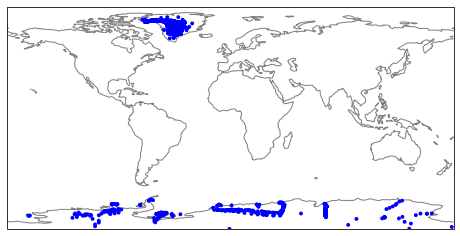

In [8]:
# Create a figure and axes for plotting all locations globally
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines(color='gray')

# Plot locations
ax.scatter(df_meta.Longitude,df_meta.Latitude,transform=ccrs.PlateCarree(),
           zorder=10,c='b',edgecolor='none',s=15);

#### 1.3.2. Antarctica

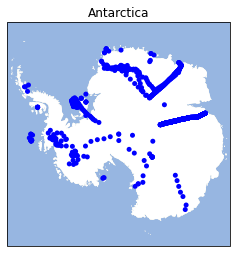

In [9]:
# Set up figure for plotting 
fig = plt.figure(figsize=(4,5))
fig.patch.set_facecolor('w')

# Create axis with correct projection and extent
ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax.set_title('Antarctica')

# Add features
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                     edgecolor='none',facecolor=cfeature.COLORS['water'])
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',facecolor=cfeature.COLORS['land'])
glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
                                       edgecolor='none',facecolor='w')
ax.add_feature(ocean,zorder=0)
ax.add_feature(land,zorder=1)
ax.add_feature(glacier,zorder=2)

# Plot locations
ax.scatter(df_antarctica_meta.Longitude,df_antarctica_meta.Latitude,
           transform=ccrs.PlateCarree(),zorder=5,
           c='b',s=25,edgecolor='none');

#### 1.3.3. Greenland

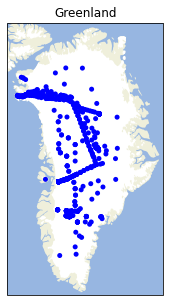

In [10]:
# Set up figure for plotting 
fig = plt.figure(figsize=(4,5))
fig.patch.set_facecolor('w')

# Create axis with correct projection and extent
ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_extent([-56.5, -30, 59, 84], ccrs.PlateCarree())
ax.set_title('Greenland')

# Add features
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                     edgecolor='none',facecolor=cfeature.COLORS['water'])
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',facecolor=cfeature.COLORS['land'])
glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
                                       edgecolor='none',facecolor='w')
ax.add_feature(ocean,zorder=0)
ax.add_feature(land,zorder=1)
ax.add_feature(glacier,zorder=2)

# Plot locations
ax.scatter(df_greenland_meta.Longitude,df_greenland_meta.Latitude,
           transform=ccrs.PlateCarree(),zorder=5,
           c='b',s=25,edgecolor='none');

### 1.4. Plot density profiles

#### 1.4.1. Create plotting functions

In [11]:
def plot_basic(profile):
    """
    Provide a single profile number to plot a basic density profile.
    """
    # Set up figure and axes for plotting
    fig, ax = plt.subplots(1,figsize=(2,4))
    fig.patch.set_facecolor('#FFFFFF')
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(r'Density (kg m$^{-3}$)')

    # Select the profile
    df_profile = df[df.Profile==profile]

    # Plot as line or step function depending on depth given
    if df_profile.Start_Depth.iloc[0] != -9999:
        ax.step(np.append(df_profile.Density.values,df_profile.Density.values[-1]),
                np.append(df_profile.Start_Depth.values,df_profile.Stop_Depth.values[-1]),c='b',lw=1)
    else:
        ax.plot(df_profile.Density,df_profile.Midpoint,c='b',lw=1)

    plt.tight_layout()
#     plt.savefig('figures/profile-'+str(df_profile.Profile.values[0])+'.png',dpi=100)
#     plt.close(fig)
        
def plot_detailed(profile):
    """
    Provide a single profile number to plot a density profile with location and metadata.
    """
    # Set up figure and axes for plotting
    fig, ax = plt.subplots(1,figsize=(3,4.5))
    fig.patch.set_facecolor('#FFFFFF')
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(r'Density (kg m$^{-3}$)')

    # Select the profile
    df_profile = df[df.Profile==profile].reset_index(drop=True)
    
    # Create a label from metadata
    label = 'Profile: {}\nCitation: {:.0f}\nLat: {:.2f}\nLon: {:.2f}\nElev: {:.0f} m\nDate: {}'.format(
                    profile,df_profile.Citation[0],df_profile.Latitude[0],df_profile.Longitude[0],
                    df_profile.Elevation[0],df_profile.Timestamp[0])

    # Plot as line or step function depending on depth given
    if df_profile.Start_Depth.iloc[0] != -9999:
        ax.step(np.append(df_profile.Density.values,df_profile.Density.values[-1]),
                np.append(df_profile.Start_Depth.values,df_profile.Stop_Depth.values[-1]),label=label,c='b')
    else:
        ax.plot(df_profile.Density,df_profile.Midpoint,label=label,c='b')

    
    # Add legend
    legend = ax.legend(prop={'size':8}, bbox_to_anchor=(-0.0075,1.015), loc='lower left',borderpad=0.1,labelspacing=1.0)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_boxstyle('Square')
    
    # Add map
    if df_profile.Latitude[0] < 0:
        ax_map = inset_axes(ax, width=0.8, height=0.8, bbox_to_anchor=(1,1.02),bbox_transform=ax.transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo()))
        ax_map.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    else:
        ax_map = inset_axes(ax, width=1, height=0.975, bbox_to_anchor=(1.065,1.02),bbox_transform=ax.transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.NorthPolarStereo(central_longitude=-45)))
        ax_map.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())

    ax_map.axes.xaxis.set_ticks([])
    ax_map.axes.yaxis.set_ticks([])
    ax_map.coastlines(resolution='110m',color='gray',zorder=0)   
    
    # Plot location
    ax_map.scatter(df_profile.Longitude[0],df_profile.Latitude[0],
            transform=ccrs.PlateCarree(),s=60,marker='*',c='b')

#### 1.4.2. Use plotting functions 

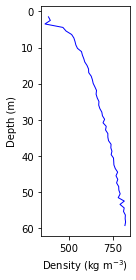

In [12]:
# Basic plot for profile 30
plot_basic(30)

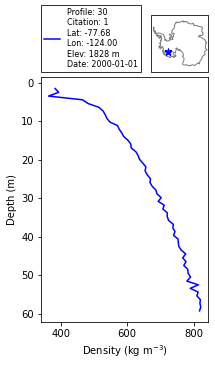

In [13]:
# Detailed plot for profile 30
plot_detailed(30)

***

## 2. Subdataset: Annual Accumulation

### 2.1. Open and view dataset

In [14]:
# Open data as a dataframe
df = pd.read_csv(accumulation)

# Get unique locations of measurements
df_meta = df.groupby(['Latitude','Longitude']).size().reset_index().rename(columns={0:'n_measurements'})

# Print out the first few lines
df.head()

,Name,Citation,Method,Date,Timestamp,Start_Year,End_Year,Year,Latitude,Longitude,Elevation,Radar_Horizontal_Resolution,Accumulation,Error
0,6.0,1,1,19950000.0,1995-01-01,-9999.0,-9999.0,1989.0,-90.0,0.0,2850.0,-9999.0,0.0849,-9999.0
1,6.0,1,1,19950000.0,1995-01-01,-9999.0,-9999.0,1988.0,-90.0,0.0,2850.0,-9999.0,0.0740,-9999.0
2,6.0,1,1,19950000.0,1995-01-01,-9999.0,-9999.0,1987.0,-90.0,0.0,2850.0,-9999.0,0.0652,-9999.0
3,6.0,1,1,19950000.0,1995-01-01,-9999.0,-9999.0,1986.0,-90.0,0.0,2850.0,-9999.0,0.1301,-9999.0
4,6.0,1,1,19950000.0,1995-01-01,-9999.0,-9999.0,1985.0,-90.0,0.0,2850.0,-9999.0,0.0767,-9999.0


In [15]:
# Print basic information about the dataset
print('Number of individual measurements: {}'.format(len(df)))
print('Number of unique locations: {}'.format(len(df_meta)))

Number of individual measurements: 301408
Number of unique locations: 97178


### 2.2. Partition dataset into Antarctica and Greenland

In [16]:
# Split dataset
df_greenland = df[df.Latitude>0]
df_antarctica = df[df.Latitude<0]

# Split metadata
df_greenland_meta = df_meta[df_meta.Latitude>0]
df_antarctica_meta = df_meta[df_meta.Latitude<0]

In [17]:
# Print info by ice sheet
print('Antarctica')
print('Number of measurements: {}'.format(len(df_antarctica)))
print('Number of unique locations: {}'.format(len(df_antarctica_meta)))
print('Earliest measurement: {}'.format(df_antarctica.Timestamp.min()))
print('Most recent measurement: {}'.format(df_antarctica.Timestamp.max()))

print('\nGreenland')
print('Number of measurements: {}'.format(len(df_greenland)))
print('Number of unique locations: {}'.format(len(df_greenland_meta)))
print('Earliest measurement: {}'.format(df_greenland.Timestamp.min()))
print('Most recent measurement: {}'.format(df_greenland.Timestamp.max()))

Antarctica
Number of measurements: 156709
Number of unique locations: 76846
Earliest measurement: 1980-02-01
Most recent measurement: 2014-01-08

Greenland
Number of measurements: 144699
Number of unique locations: 20332
Earliest measurement: 1987-01-01
Most recent measurement: 2017-06-16


### 2.3. Plot locations

NOTE: Since there are so many, these cells take a long time to run. They are commented out so the file does not become too large.

#### 2.3.1. Globally

In [18]:
# # Create a figure and axes for plotting all locations globally
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
# ax.coastlines(color='gray')

# # Plot locations
# ax.scatter(df_meta.Longitude,df_meta.Latitude,transform=ccrs.PlateCarree(),
#            zorder=10,c='dodgerblue',edgecolor='none',s=15);

#### 2.3.2. Antarctica

In [19]:
# # Set up figure for plotting 
# fig = plt.figure(figsize=(6,6))
# fig.patch.set_facecolor('w')

# # Create axis with correct projection and extent
# ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
# ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
# ax.set_title('Antarctica')

# # Add features
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
#                                      edgecolor='none',facecolor=cfeature.COLORS['water'])
# land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
#                                     edgecolor='none',facecolor=cfeature.COLORS['land'])
# glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
#                                        edgecolor='none',facecolor='w')
# iceshelves = cfeature.NaturalEarthFeature('physical','antarctic_ice_shelves_polys','50m',
#                                           edgecolor='none',facecolor='#dddddd')
# ax.add_feature(ocean,zorder=0)
# ax.add_feature(land,zorder=1)
# ax.add_feature(glacier,zorder=2)
# ax.add_feature(iceshelves,zorder=3)

# # Plot locations
# ax.scatter(df_antarctica_meta.Longitude,df_antarctica_meta.Latitude,
#            transform=ccrs.PlateCarree(),zorder=5,
#            c='dodgerblue',s=30,edgecolor='none');

#### 2.3.3. Greenland

In [20]:
# # Set up figure for plotting 
# fig = plt.figure(figsize=(4,5))
# fig.patch.set_facecolor('w')

# # Create axis with correct projection and extent
# ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=-45))
# ax.set_extent([-56.5, -30, 59, 84], ccrs.PlateCarree())
# ax.set_title('Greenland')

# # Add features
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
#                                      edgecolor='none',facecolor=cfeature.COLORS['water'])
# land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
#                                     edgecolor='none',facecolor=cfeature.COLORS['land'])
# glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
#                                        edgecolor='none',facecolor='w')
# ax.add_feature(ocean,zorder=0)
# ax.add_feature(land,zorder=1)
# ax.add_feature(glacier,zorder=2)

# # Plot locations
# ax.scatter(df_greenland_meta.Longitude,df_greenland_meta.Latitude,
#            transform=ccrs.PlateCarree(),zorder=5,
#            c='dodgerblue',s=25,edgecolor='none');

***

## 3. Subdataset: Borehole Temperature

### 3.1. Open and view dataset

In [21]:
# Open data as a dataframe
df = pd.read_csv(temperature)

# Print out the first few lines
df.head()

,Name,Citation,Method,Date,Timestamp,Latitude,Longitude,Elevation,Depth,Open_Time,Duration,Temperature,Error
0,1,1,-9999,19840124,1984-01-24,-77.57861,-50.57944,58,10.0,-9999,-9999.0,-25.8,-9999.0
1,2,1,-9999,19860128,1986-01-28,-78.87167,-53.40333,-9999,10.0,-9999,-9999.0,-25.8,-9999.0
2,3,1,-9999,19840122,1984-01-22,-77.12917,-50.50139,43,10.0,-9999,-9999.0,-24.7,-9999.0
3,4,1,-9999,19840127,1984-01-27,-77.86722,-52.80417,69,10.0,-9999,-9999.0,-25.9,-9999.0
4,5,1,-9999,19840130,1984-01-30,-78.24194,-54.04694,67,10.0,-9999,-9999.0,-26.3,-9999.0


In [22]:
# Print basic information about the dataset
print('Number of individual measurements: {}'.format(len(df)))

Number of individual measurements: 774


### 3.2. Partition dataset into Antarctica and Greenland

In [23]:
# Split dataset
df_greenland = df[df.Latitude>0]
df_antarctica = df[df.Latitude<0]

In [24]:
# Print info by ice sheet
print('Antarctica')
print('Number of measurements: {}'.format(len(df_antarctica)))
print('Earliest measurement: {}'.format(df_antarctica.Timestamp.min()))
print('Most recent measurement: {}'.format(df_antarctica.Timestamp.max()))

print('\nGreenland')
print('Number of measurements: {}'.format(len(df_greenland)))
print('Earliest measurement: {}'.format(df_greenland.Timestamp.min()))
print('Most recent measurement: {}'.format(df_greenland.Timestamp.max()))

Antarctica
Number of measurements: 757
Earliest measurement: 1957-01-02
Most recent measurement: 2014-01-07

Greenland
Number of measurements: 17
Earliest measurement: 2013-04-12
Most recent measurement: 2017-06-10


### 3.3. Plot locations

#### 3.3.1. Globally

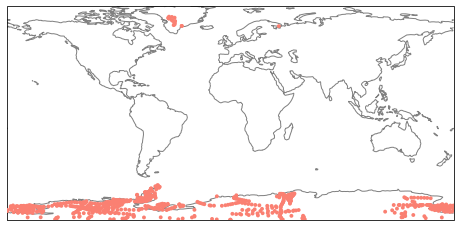

In [25]:
# Create a figure and axes for plotting all locations globally
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines(color='gray')

# Plot locations
ax.scatter(df.Longitude,df.Latitude,transform=ccrs.PlateCarree(),
           zorder=10,c='salmon',edgecolor='none',s=15);

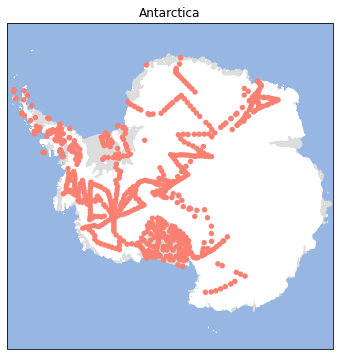

In [26]:
# Set up figure for plotting 
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('w')

# Create axis with correct projection and extent
ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax.set_title('Antarctica')

# Add features
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                     edgecolor='none',facecolor=cfeature.COLORS['water'])
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',facecolor=cfeature.COLORS['land'])
glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
                                       edgecolor='none',facecolor='w')
iceshelves = cfeature.NaturalEarthFeature('physical','antarctic_ice_shelves_polys','50m',
                                          edgecolor='none',facecolor='#dddddd')
ax.add_feature(ocean,zorder=0)
ax.add_feature(land,zorder=1)
ax.add_feature(glacier,zorder=2)
ax.add_feature(iceshelves,zorder=3)

# Plot locations
ax.scatter(df_antarctica.Longitude,df_antarctica.Latitude,
           transform=ccrs.PlateCarree(),zorder=5,
           c='salmon',s=30,edgecolor='none');

#### 3.3.3. Greenland

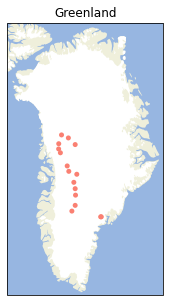

In [27]:
# Set up figure for plotting 
fig = plt.figure(figsize=(4,5))
fig.patch.set_facecolor('w')

# Create axis with correct projection and extent
ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_extent([-56.5, -30, 59, 84], ccrs.PlateCarree())
ax.set_title('Greenland')

# Add features
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                     edgecolor='none',facecolor=cfeature.COLORS['water'])
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',facecolor=cfeature.COLORS['land'])
glacier = cfeature.NaturalEarthFeature('physical','glaciated_areas','50m',
                                       edgecolor='none',facecolor='w')
ax.add_feature(ocean,zorder=0)
ax.add_feature(land,zorder=1)
ax.add_feature(glacier,zorder=2)

# Plot locations
ax.scatter(df_greenland.Longitude,df_greenland.Latitude,
           transform=ccrs.PlateCarree(),zorder=5,
           c='salmon',s=25,edgecolor='none');

***

## 4. Subdataset: Snow Depth on Sea Ice

### 4.1. Open and view dataset

In [28]:
# Open data as a dataframe
df = pd.read_csv(snowdepth)

# Get unique locations of measurements
df_meta = df.groupby(['Latitude','Longitude']).size().reset_index().rename(columns={0:'n_measurements'})

# Print out the first few lines
df.head()

,Citation,Method,Date,Timestamp,Latitude,Longitude,Distance_Along_Transect,Snow_Depth,Snow_Depth_Error,Density_Flag,Sea_Ice_Thickness,Sea_Ice_Thickness_Error,Sea_Ice_Type,Sea_Ice_Freeboard,Sea_Ice_Freeboard_Error,Snow_Ice_Thickness,Snow_Ice_Thickness_Error,Radar_Horizontal_Resolution
0,2,1,19901113,1990-11-13,64.9333,24.6667,-9999.0,0.0,-9999.0,0,0.0,-9999.0,1,-9999.0,-9999.0,-9999.0,-9999.0,-9999
1,2,1,19901113,1990-11-13,65.1233,25.2400,-9999.0,0.0,-9999.0,0,0.0,-9999.0,1,-9999.0,-9999.0,0.0,-9999.0,-9999
2,2,1,19901113,1990-11-13,64.2233,24.7000,-9999.0,0.0,-9999.0,0,0.0,-9999.0,1,-9999.0,-9999.0,0.0,-9999.0,-9999
3,2,1,19901113,1990-11-13,63.8900,22.9467,-9999.0,0.0,-9999.0,0,0.0,-9999.0,1,-9999.0,-9999.0,0.0,-9999.0,-9999
4,2,1,19901113,1990-11-13,63.7300,22.5917,-9999.0,0.0,-9999.0,0,0.0,-9999.0,1,-9999.0,-9999.0,0.0,-9999.0,-9999


In [29]:
# Print basic information about the dataset
print('Number of individual measurements: {}'.format(len(df)))
print('Number of unique locations: {}'.format(len(df_meta)))

Number of individual measurements: 92712
Number of unique locations: 74399


### 4.2. Partition dataset into Northern and Southern Hemispheres

In [30]:
# Split dataset
df_n = df[df.Latitude>0]
df_s = df[df.Latitude<0]

# Split metadata
df_n_meta = df_meta[df_meta.Latitude>0]
df_s_meta = df_meta[df_meta.Latitude<0]

In [31]:
# Print info by ice sheet
print('SH')
print('Number of measurements: {}'.format(len(df_s)))
print('Number of unique locations: {}'.format(len(df_s_meta)))

print('\nNH')
print('Number of measurements: {}'.format(len(df_n)))
print('Number of unique locations: {}'.format(len(df_n_meta)))

SH
Number of measurements: 3176
Number of unique locations: 12

NH
Number of measurements: 89536
Number of unique locations: 74387


### 4.3. Plot locations

NOTE: Since there are so many, these cells take a long time to run. They are commented out so the file does not become too large.

#### 4.3.1. Globally

In [32]:
# # Create a figure and axes for plotting all locations globally
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
# ax.coastlines(color='gray')
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

# # Plot locations
# ax.scatter(df_meta.Longitude,df_meta.Latitude,transform=ccrs.PlateCarree(),
#            zorder=10,c='b',edgecolor='none',s=15);

#### 4.3.2. Southern Hemisphere

In [33]:
# # Create a figure and axes for plotting all locations globally
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
# ax.coastlines(color='gray')
# ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())

# # Plot locations
# ax.scatter(df_s_meta.Longitude,df_s_meta.Latitude,transform=ccrs.PlateCarree(),
#            zorder=10,c='b',edgecolor='none',s=30);

#### 4.3.3. Northern Hemisphere

In [34]:
# # Create a figure and axes for plotting all locations globally
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
# ax.coastlines(color='gray')
# ax.set_extent([-180, 180, 50,90], ccrs.PlateCarree())

# # Plot locations
# ax.scatter(df_n_meta.Longitude,df_n_meta.Latitude,transform=ccrs.PlateCarree(),
#            zorder=10,c='b',edgecolor='none',s=30);